# Scenario modelling

## Set up environment

In [1]:
CM_BASEPATH = '../cibusmod'

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), CM_BASEPATH))

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cvxpy

In [3]:
from CIBUSmod.utils.misc import inv_dict, aggregate_data_coords_pair
from CIBUSmod.optimisation.indexed_matrix import IndexedMatrix
from CIBUSmod.optimisation.utils import make_cvxpy_constraint
from itertools import product

In [4]:
# Create session
session = cm.Session(
    name = 'main',
    data_path = CM_BASEPATH + "/data",
    data_path_default = CM_BASEPATH + "/data/default",
    data_path_scenarios = "./workbooks"
)

# Load scenarios
session.add_scenario(
    "SCN_BASE",
    years=[2020],
    pars = "all",
    scenario_workbooks="base"
)

session.add_scenario(
    "BASELINE",
    years=[2020],
    pars = "all",
    scenario_workbooks="default_fix"
)

A scenario with the name 'SCN_BASE' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name 'BASELINE' already exists use .update_scenario() or .remove_scenario() instead.


In [5]:
%%time

scn = "SCN_BASE"

retrievers = {
    'Regions': cm.ParameterRetriever('Regions'),
    'DemandAndConversions': cm.ParameterRetriever('DemandAndConversions'),
    'CropProduction': cm.ParameterRetriever('CropProduction'),
    'FeedMgmt': cm.ParameterRetriever('FeedMgmt'),
    'GeoDistributor': cm.ParameterRetriever('GeoDistributor'),
}

cm.ParameterRetriever.update_all_parameter_values(**session[scn], year=2020)

# Instatiate Regions
regions = cm.Regions(
    par = retrievers['Regions'],
)

# Instantiate DemandAndConversions
demand = cm.DemandAndConversions(
    par = retrievers['DemandAndConversions'],
)

# Instantiate CropProduction
crops = cm.CropProduction(
    par = retrievers['CropProduction'],
    index = regions.data_attr.get('x0_crops').index
)

# Instantiate AnimalHerds
# Each AnimalHerd object is stored in an indexed pandas.Series
herds = cm.make_herds(regions)

# Instantiate feed management
feed_mgmt = cm.FeedMgmt(
    herds = herds,
    par = retrievers['FeedMgmt'],
)

# Instantiate geo distributor
optproblem = cm.FeedDistributor(
    regions = regions,
    demand = demand,
    crops = crops,
    herds = herds,
    feed_mgmt = feed_mgmt,
    par = retrievers['GeoDistributor'],
)

self = optproblem

/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:152: UserWarning: 
-----------------------------------------------------------------------------
Some filter values included in data were not available in relation_tables.xlsx.
Missing for 'feed': 'maize gluten meal', 'rapeseed cake', 'minerals'
Missing for 'by_prod': 'palm kernel expeller', 'maize gluten meal', 'fish meal', 'soybean meal', 'cream', 'luzern meal', 'soybean protein concentrate'
------------------------------------------------------------------------------
  warnings.warn(f"""


CPU times: user 3.34 s, sys: 49.5 ms, total: 3.39 s
Wall time: 3.39 s


In [6]:
cm.ParameterRetriever.update_all_parameter_values()
cm.ParameterRetriever.update_relation_tables()

cm.ParameterRetriever.update_all_parameter_values(**session[scn], year=2020)

regions.calculate()
demand.calculate()
crops.calculate()
for h in herds:
    h.calculate()

self.make(use_cons=[1, 2, 3, 4, 5, 6, 10, 11, 12, 14], verbose=True)

/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:152: UserWarning: 
-----------------------------------------------------------------------------
Some filter values included in data were not available in relation_tables.xlsx.
Missing for 'feed': 'maize gluten meal', 'rapeseed cake', 'minerals'
Missing for 'by_prod': 'palm kernel expeller', 'maize gluten meal', 'fish meal', 'soybean meal', 'cream', 'luzern meal', 'soybean protein concentrate'
------------------------------------------------------------------------------
  warnings.warn(f"""
/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:152: UserWarning: 
-----------------------------------------------------------------------------
Some filter values included in data were not available in relation_tables.xlsx.
Missing for 'feed': 'maize gluten meal', 'rapeseed cake', 'minerals'
Missing for 'by_prod': 'palm kernel expeller', 'maize gluten meal', 'fish meal', 'soybean meal', 'cream', 'luzern meal', 'soybean pro

[AAT, DM, ME, fat, PBV] [AAT, DM, ME, fat, PBV] [AAT, DM, ME, fat, PBV] [AAT, DM, ME, fat, PBV] [AAT, DM, ME, fat, PBV] [AAT, DM, ME, fat, PBV] [ME] [ME] [ME] [ME] [ME] [ME] [ME] [ME] [NE] [NE] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [DM] [09:30:19][FeedDistributor.make] Getting x0 and making indexes ... 6.8s
[09:30:26][FeedDistributor.make] Creating demand vector ... 0.0s
[09:30:26][FeedDistributor.make] Calculating scaling factors ... 0.0s
[09:30:26][FeedDistributor.make] Making objective O1 ... 0.2s
[09:30:26][FeedDistributor.make] Making constraint C1... 1.2s
[09:30:27][FeedDistributor.make] Making constraint C2... 0.4s
[09:30:28][FeedDistributor.make] Making constraint C3... 0.4s
[09:30:28][FeedDistributor.make] Making constraint C4... 0.3s
[09:30:28][FeedDistributor.make] Making constraint C5... 0.5s
[09:30:29][FeedDistributor.make] Making constraint C6... 0.8s
[09:30:30][FeedDistributor.make] Making constraint C10... 0.4s
[09:30:30][FeedDistributor.make] Making co

## Data debugging

### Ensure feed_to_prod matches feeds

In [7]:
feed_to_prod_feeds = set(feed_mgmt.par.get_unique("feed", qry='parameter=="feed_to_prod"').tolist())
missing_feeds = set()
for herd in self.herds:
    missing_feeds.update(set(filter(
        lambda f: f not in feed_to_prod_feeds,
        herd.par.get_unique("feed")
    )))
print(missing_feeds)

{'minerals'}


### List any crop/by products that are 100% imported

In [8]:
imported = {}
keys = ["crop_prod", "by_prod"]
for bp_or_cp in keys:
    feed_to_by_prod = self._get_feed_to_prod_factors(bp_or_cp, index=True)
    _imported = feed_to_by_prod[feed_to_by_prod["share_domestic"] == 0][["feed_to_prod"]]
    imported[bp_or_cp] = list(_imported.index.unique("feed"))
    
set([x for k in keys for x in imported[k]])

{'fish meal',
 'linseed',
 'luzern meal',
 'maize gluten meal',
 'palm kernel expeller',
 'potatoe protein',
 'soybean meal',
 'soybean protein concentrate',
 'soybeans',
 'sugar beet molasses',
 'sugar beet pulp',
 'sunflower seed meal',
 'whey',
 'whey powder'}

## Improve numerics

In [9]:
def print_ranges():
    for k, v in self.matrices().items():
        M = abs(v.M)
        M = M[M > 0]
        M_minmax = [M.min(), M.max()]
        e_min, e_max = np.log10(M_minmax)
        rng = e_max-e_min
        if rng>4:
            print(f"{k}: {int(rng):,} {tuple(M_minmax)}")

print("RANGES BEFORE:")
print_ranges()

# "We recommend that you scale the matrix coefficients so that their range 
# is contained in six orders of magnitude or less, and hopefully within [1e-3, 1e6]."

# AND:
# rhs should be on the order of 1e4 or less
# optimal value is less than 1e4


def rescale_constraints():
    constraints_to_scale = filter(
        lambda cons_label: any([c_nr in cons_label for c_nr in ["C1", "C12"]]),
        self.constraints.keys()
    )
    for cons_label in constraints_to_scale:
        cons = self.constraints[cons_label]
        for par_k in cons["pars"].keys():
            v = cons["pars"][par_k]
            if hasattr(v, 'M'):
                v.M /= (max(abs(v.M.max()), abs(v.M.min())) / 100)
            else:
                cons["pars"][par_k] /= (max(abs(v.max()), abs(v.min())) / 100)
    

RANGES BEFORE:
C1.A1: 5 (0.768598442, 138600.6558)
C2.A2: 4 (0.348837209302326, 12246.95957)
C5.A5: 4 (0.145, 2117.89396575)
C11 (eq).A11: 7 (3.1504346010372534e-08, 1.0)
C12 (min).A12: 5 (1.96, 611906.1017936878)
C12 (eq).A12: 5 (0.3333793423362912, 80513.96076232735)
C12 (max).A12: 5 (0.7941999999999999, 109575.0)


In [10]:
def improve_numerics(self):
    from CIBUSmod.optimisation.feed_dist import IndexedMatrix
   
    for name, C in self.constraints.items():
        M = [obj for obj in C['pars'].values() if isinstance(obj, IndexedMatrix)]
        assert len(M) == 1, "Expected one and only one IndexedMatrix"
        M = M[0]
        max_val = M.M.max()
        for name, obj in C['pars'].items():
            if isinstance(obj,IndexedMatrix):
                obj.M = obj.M / max_val
            else:
                obj[:] = obj / max_val
    print("Completed rescaling of matrices.")

improve_numerics(optproblem)

Completed rescaling of matrices.


# Replace the objective function

While the original optimisation objective focused on minimising the change, we now instead want to maximize the protein contents.

## Mapping `x` to protein contents

First we need to create a row-array that maps each element in `x` with its protein content, so that we compute the aggregate protein amount from the decision variable.

In [11]:
ADDED_WHEAT = "Wheat (add)"
ADDED_PEAS = "Peas (add)"

PROTEIN_CONTENTS = {
    ADDED_PEAS: 220,
    ADDED_WHEAT: 67.15,
    "meat": 155.5,
    "milk": 35.0,
}

# Convert to thousands of prot. / kg, instead of straight
for k in PROTEIN_CONTENTS.keys():
    PROTEIN_CONTENTS[k] /= 1e3

def make_protein_mask_ani():
    RELEVANT_ANIMAL_PRODUCTS = ["meat", "milk"]
    
    # Get row index from animal product demand vector (ps,sp,ap)
    row_idx = pd.MultiIndex.from_tuples(
        [
            ("conventional", "cattle", "meat"),
            ("conventional", "cattle", "milk"),
            ("organic", "cattle", "meat"),
            ("organic", "cattle", "milk"),
        ],
        names=["prod_system", "species", "animal_prod"]
    )

    # Get col index from animal herds (sp,br,ps,ss,re)
    col_idx = self.x_idx["ani"]

    # To store data and corresponding row/col numbers for constructing matrix
    val = []
    row_nr = []
    col_nr = []

    # Go through animal herds
    for herd in self.herds:
        sp = herd.species
        br = herd.breed
        ps = herd.prod_system
        ss = herd.sub_system

        if sp != "cattle":
            continue

        def get_uniq(col):
            return herd.data_attr.get("production").columns.unique(col)
        
        # Get all animal products that we are concerned with
        aps = set(get_uniq("animal_prod")) & set(RELEVANT_ANIMAL_PRODUCTS)
        opss = get_uniq("prod_system")
        
        for ap, ops in product(aps, opss):
            if (ops, sp, ap) not in row_idx:
                continue
        
            # Get production of animal product (ap) from output production system (ops) per head
            # of defining animal of species (sp) and breed (br) in production system (ps), sub system (ss)
            # and region (re)
            res = (
                herd.data_attr.get("production")
                .loc[:, (ops, slice(None), ap)]
                .sum(axis=1)
            ) * PROTEIN_CONTENTS[ap]
        
            if all(res == 0):
                continue
        
            val.extend(res)
            col_nr.extend([col_idx.get_loc((sp, br, ps, ss, re)) for re in res.index])
            row_nr.extend(np.zeros(len(res)))

    # Aggregate data_coords_pair to ensure that any overlapping values are summed rather than replace each other
    val, (row_nr, col_nr) = aggregate_data_coords_pair(val, row_nr, col_nr)

    # Create Compressed Sparse Column matrix
    return scipy.sparse.coo_array((val, (row_nr, col_nr)), shape=(1, len(col_idx))).tocsc()

def make_protein_mask_crp():
    wheat_locs = self.x_idx["crp"].get_locs((ADDED_WHEAT, ))
    peas_locs = self.x_idx["crp"].get_locs((ADDED_PEAS, ))

    val = ([PROTEIN_CONTENTS[ADDED_WHEAT]] * len(wheat_locs)) + ([PROTEIN_CONTENTS[ADDED_PEAS]] * len(peas_locs))
    col_nr = [*wheat_locs, *peas_locs]
    row_nr = np.zeros(len(val))

    return scipy.sparse.coo_array(
        (val, (row_nr, col_nr)),
        shape=(1, len(self.x_idx["crp"]))
    ).tocsc()

def make_protein_mask():
    A_ani = make_protein_mask_ani()
    A_crp = make_protein_mask_crp()
    A_fds = scipy.sparse.csc_matrix((1, len(self.x_idx["fds"])))

    return scipy.sparse.hstack([A_ani, A_crp, A_fds], format="csc")

make_protein_mask()

<Compressed Sparse Column sparse array of dtype 'float64'
	with 848 stored elements and shape (1, 390292)>

In [12]:
# For debugging: matrix masking only number of cattle
def max_cattle_map():
    cattle_locs = self.x_idx["ani"].get_locs(("cattle", ))

    val = np.ones(len(cattle_locs))
    col_nr = [*cattle_locs]
    row_nr = np.zeros(len(val))

    A_ani = scipy.sparse.coo_array(
        (val, (row_nr, col_nr)),
        shape=(1, len(self.x_idx["ani"]))
    ).tocsc()
    A_crp = scipy.sparse.csc_matrix((1, len(self.x_idx["crp"])))
    A_fds = scipy.sparse.csc_matrix((1, len(self.x_idx["fds"])))

    return scipy.sparse.hstack([A_ani, A_crp, A_fds], format="csc")

#max_cattle_map()

### Quick validity check

Ensure we only have values in the protein map where we expect to, i.e. for the added crops and for cattle.

In [13]:
df_ani = pd.DataFrame(make_protein_mask_ani(), columns=self.x_idx["ani"])
df_crp = pd.DataFrame(make_protein_mask_crp(), columns=self.x_idx["crp"])

# Check that only the added crops have values in the crp part of the mask
ADDED_CROPS = ["Wheat (add)", "Peas (add)"]

for crop in df_crp.columns.unique("crop"):
    is_all_zeroes = (df_crp.loc[:,(crop, slice(None), slice(None))]==0).all().all()
    assert is_all_zeroes == (crop not in ADDED_CROPS)

# Check that only cattle has values in the ani part of the protein mask
for sp in df_ani.columns.unique("species"):
    is_all_zeroes = (df_ani.loc[:,(sp, slice(None), slice(None), slice(None), slice(None))]==0).all().all()
    is_cattle = sp == "cattle"
    assert is_all_zeroes != is_cattle

## Construct and replace the `cvxpy.Problem`

In [14]:
def protein_mask_as_opt_goal():
    n = (
        len(self.x_idx_short["ani"])
        + len(self.x_idx_short["crp"])
        + len(self.x_idx_short["fds"])
    )
    x = cvxpy.Variable(n, nonneg=True)

    M = make_protein_mask()
    objective = cvxpy.Maximize(M @ x)

    # Append constraints
    constraints = [
        make_cvxpy_constraint(cons, x) for cons in self.constraints.values()
    ]

    # Define problem
    self.problem = cvxpy.Problem(
        objective=objective,
        constraints=constraints
    )

# Run model

In [15]:
%%time
if scn != "BASELINE":
    protein_mask_as_opt_goal()
    self.solve(
        apply_solution=False,
        verbose=True,
        solver_settings=[{
            "solver": "GUROBI",
            "reoptimize": True,
            "verbose": True,
    
            #"GURO_PAR_DUMP": 1,
    
            # Custom params
            "BarConvTol": 1e-8,
            # Sometimes setting Aggregate=0 can improve the model numerics
            # "Aggregate": 0,
            
            "NumericFocus": 3,
            # Useful for recognizing infeasibility or unboundedness, but a bit slower than the default algorithm.
            # values: -1 auto, 0 off, 1 force on.
            "BarHomogeneous": 1, 
    
            # Gurobi has three different heuristic algorithms to find scaling factors. Higher values for the ScaleFlag uses more aggressive heuristics to improve the constraint matrix numerics for the scaled model.
            "ScaleFlag": 2,
    
            "FeasibilityTol": 1e-3,
        }]
    )

[09:31:27][FeedDistributor.solve] Finding solution with 'GUROBI' ... ===============================================================================
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 02 09:31:27 AM: Your problem has 390292 variables, 1163722 constraints, and 0 parameters.
(CVXPY) Jan 02 09:31:27 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 02 09:31:27 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 02 09:31:27 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 02 09:31:27 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                            

# Re-run the model to redistribute land-use for minimal change

Now that we optimised for maximum protein, we re-run the model with the protein amount as a constraint, instead optimising for minimal difference from the contemporary configuration.

We thus:
- Extract the max protein value from the previous optimisation run
- Create a constraint that maps x to the protein amount and ensures it is close to the max value
- Reapply the original optimisation goal

In [16]:
print(f"Max protein calculated as:\n{self.problem.value:e}")

Max protein calculated as:
3.393443e+08


In [17]:
def protein_map_as_cons(factor=0.9):
    max_protein_amount = self.problem.value
    if max_protein_amount is None:
        raise Exception("Could not get the optimal value from the problem")

    b = max_protein_amount * factor

    return {
        "left": lambda x, M, b: M @ x - b,
        "right": lambda M, b: 0,
        "rel": ">=",
        "pars": { "M": make_protein_mask(), "b": b }
    }

self.constraints["CX: Protein"] = protein_map_as_cons(0.95)

In [18]:
# Overwrite old problem with standard optimization objective,
# but with the protein constraint added
self.problem = self.get_cvx_problem()

In [19]:
self.solve(
    apply_solution=True,
    verbose=True,
    solver_settings=[{
        "solver": "GUROBI",
        "reoptimize": True,
        "verbose": True,
    }]
)

[09:45:01][FeedDistributor.solve] Finding solution with 'GUROBI' ... ===============================================================================
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 02 09:45:01 AM: Your problem has 390292 variables, 1163723 constraints, and 0 parameters.
(CVXPY) Jan 02 09:45:01 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 02 09:45:01 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 02 09:45:01 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 02 09:45:01 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                            

In [20]:
self.feed_mgmt.calculate()

/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/retriever.py:364: UserWarning: NaNs returned! No value for 'feed_composition' found in 'FeedMgmt'.xlsx for some of the supplied filters (n=1060): 
----------
f_species = cattle
f_breed = beef
f_sub_system = other sheep
f_region = 1011
f_prod_system = conventional
f_animal = breeding bulls
f_feed = nan
f_feed_par = N
----------
f_species = cattle
f_breed = beef
f_sub_system = other sheep
f_region = 1011
f_prod_system = conventional
f_animal = bulls
f_feed = nan
f_feed_par = N
----------
f_species = cattle
f_breed = beef
f_sub_system = other sheep
f_region = 1011
f_prod_system = conventional
f_animal = calves, bull
f_feed = nan
f_feed_par = N
----------
f_species = cattle
f_breed = beef
f_sub_system = other sheep
f_region = 1011
f_prod_system = conventional
f_animal = calves, for slaughter
f_feed = nan
f_feed_par = N
----------
f_species = cattle
f_breed = beef
f_sub_system = other sheep
f_region = 1011
f_prod_system = conventional
f_anima

In [21]:
(make_protein_mask() @ (self.problem.variables()[0])).value

array([4.17765394e+12])

# Plot results

In [22]:
session.store(
    scn, 2020,
    demand, regions, crops, herds, optproblem
)

Writing outputs to '/root/cibus/cibusmod/data/output/main.sqlite'


/root/cibus/scenarios/../cibusmod/CIBUSmod/utils/session_db.py:1535: UserWarning: Negative values of down to -2017588774.3451514 */year in AnimalHerd.feed_req_min.
  warnings.warn(f'Negative values of down to {data.min().min()} {module.data_attr[attr]["unit"]} in {module_name}.{attr}.')


Outputs stored!


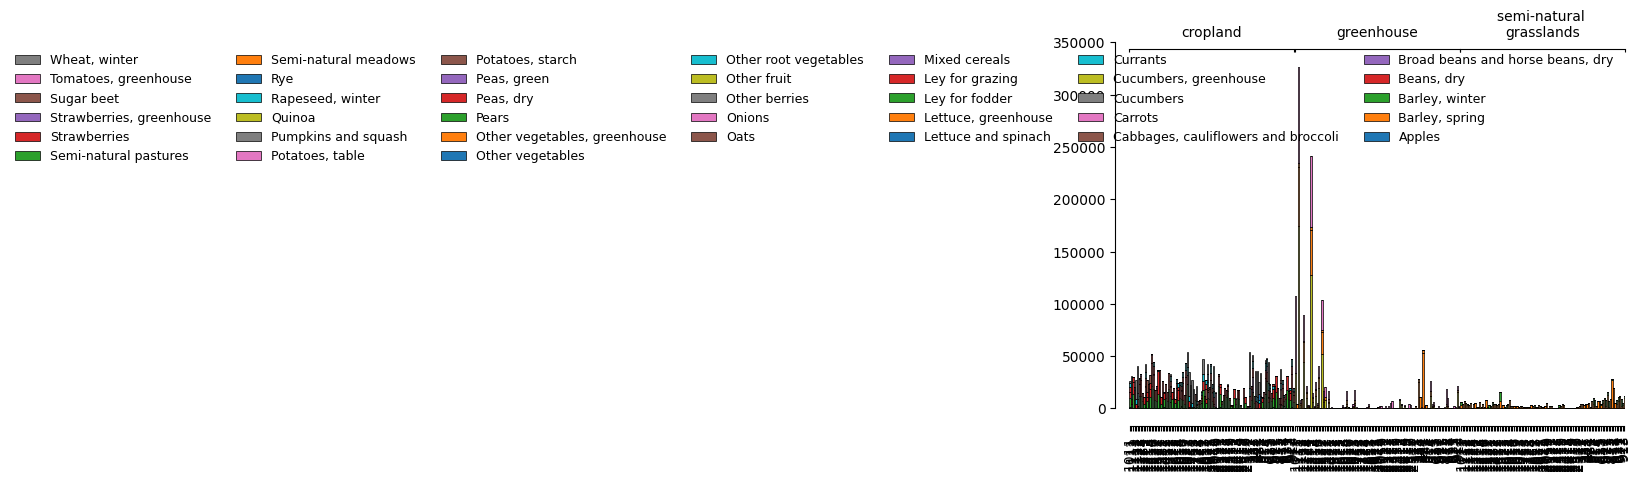

In [23]:
cm.plot.bar(
    session.get_attr('c', 'area', {'crop': ['land_use',None], 'region':None}).iloc[0].unstack('crop'),
    group_levels='land_use'
)

plt.show()   

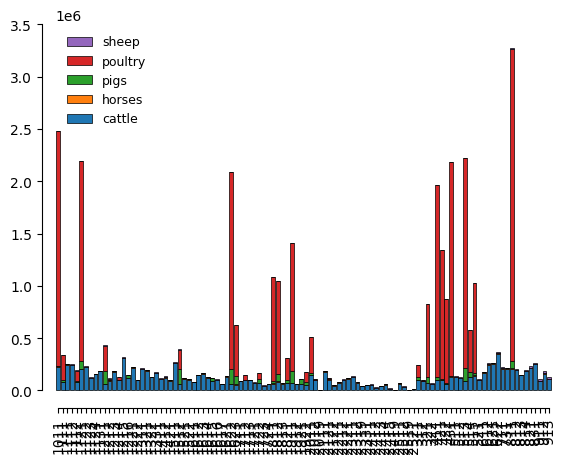

In [24]:
cm.plot.bar(
    session.get_attr('a', 'heads', ['region','species']).iloc[0].unstack('species')
)
plt.show()

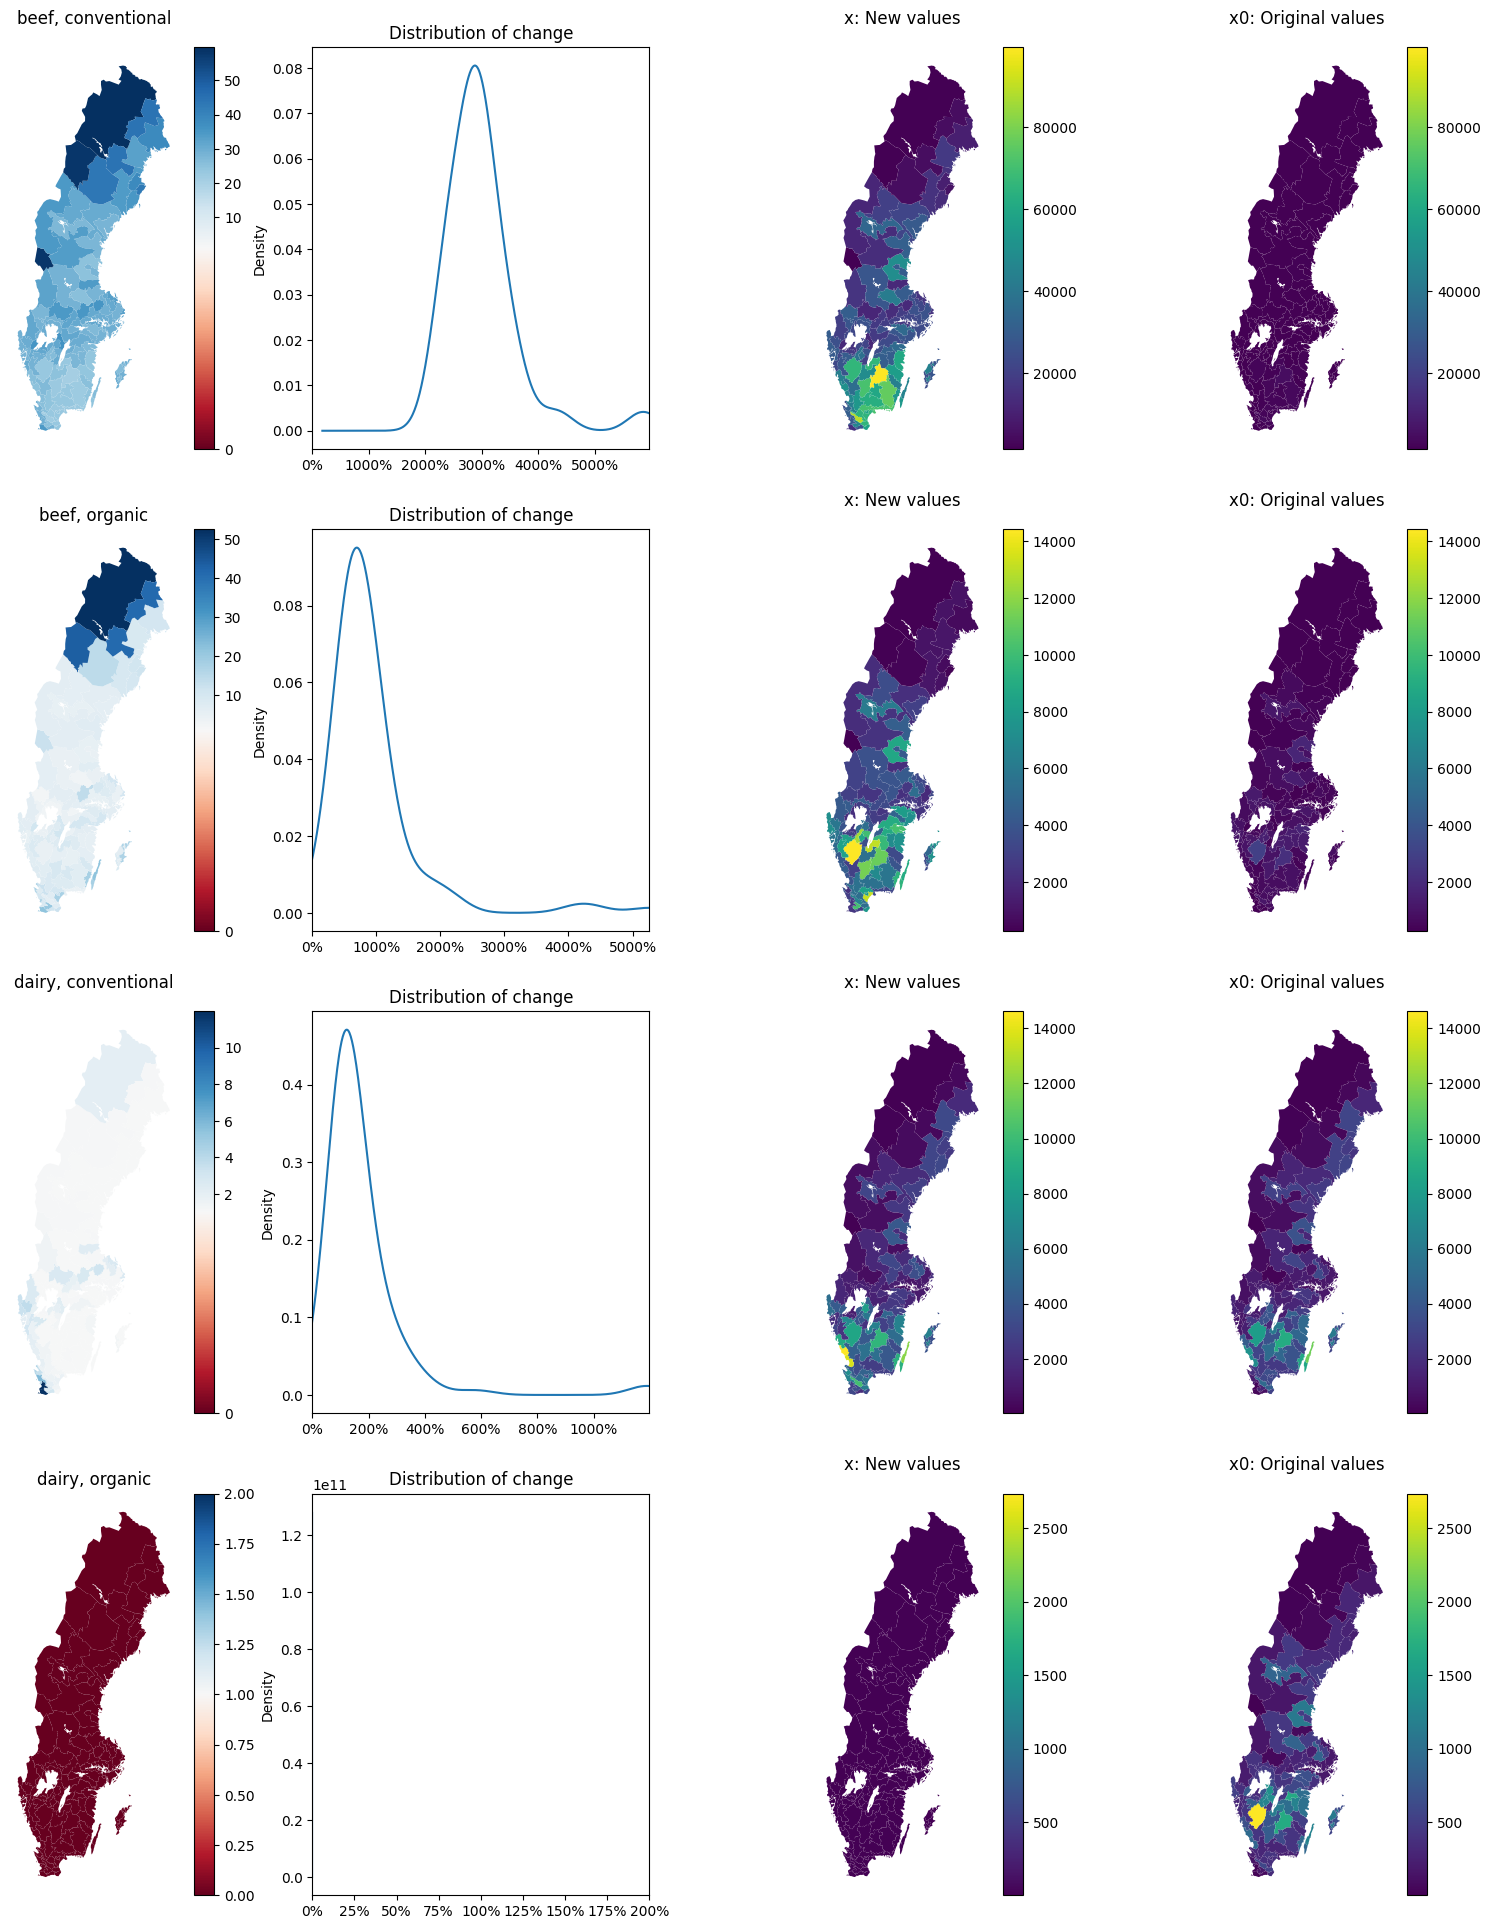

In [202]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import PercentFormatter

x0_cattle = self.x0["ani"].loc[("cattle",)]
x_cattle = self.x["ani"].loc[("cattle",)].droplevel("sub_system").groupby(["breed", "prod_system", "region"]).sum()

x0_cattle = x0_cattle.unstack("region")
x_cattle = x_cattle.unstack("region")

assert (x0_cattle.index == x_cattle.index).all(), "Expected index of x0 and x to match"

N = len(x0_cattle.index.values)
fig, axes = plt.subplots(N, 4, figsize=(20, N * 6))

for pos, axs in zip(x0_cattle.index, axes):
    (ax_l, ax_r, ax_x, ax_x0) = axs
    
    x = x_cattle.loc[pos,:]
    x0 = x0_cattle.loc[pos,:]

    # Relative change
    # ---------------
    
    ## Plot 1: Chloropleth (relative)
    x_frac = x / x0
    ### create a normalized colorscheme, with 1=100% in the centre
    vmin, vcenter, vmax, = 0, 1, max(2, x_frac.max())
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax_l.set_axis_off()
    ax_l.set_title(f"{pos[0]}, {pos[1]}")
    cm.plot.map_from_series(x_frac, ax=ax_l, cmap="RdBu", norm=norm)
    
    ## Plot 2: KDE
    x_frac.plot(kind="kde", ax=ax_r)
    ax_r.xaxis.set_major_formatter(PercentFormatter(1))
    ax_r.set_xlim([0, vmax])
    ax_r.set_title("Distribution of change")

    # Absolute values: x and x0
    # -------------------------
    ax_x.set_axis_off()
    ax_x0.set_axis_off()
    x_vmax = max(x.max(), x0.max())
    x_vmin = max(x.min(), x0.min())
    ax_x.set_title("x: New values")
    ax_x0.set_title("x0: Original values")
    cm.plot.map_from_series(x, ax=ax_x, vmin=x_vmin, vmax=x_vmax)
    cm.plot.map_from_series(x0, ax=ax_x0, vmin=x_vmin, vmax=x_vmax)

    

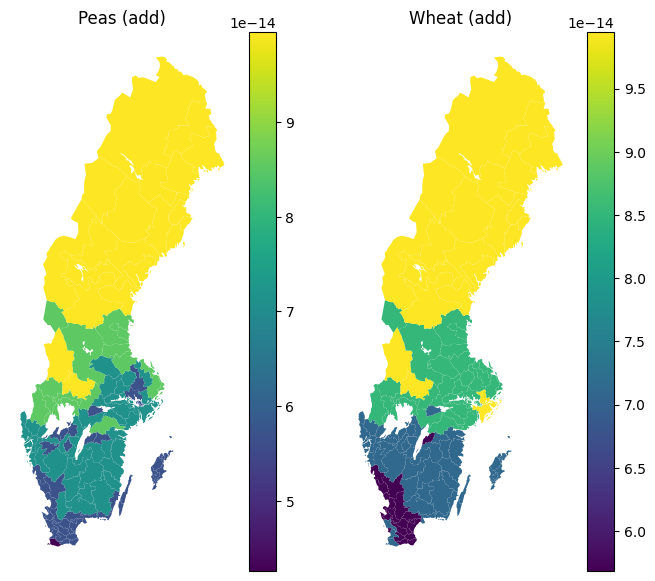

In [187]:
added_peas = self.x["crp"].xs("Peas (add)", level="crop", drop_level=False)
added_wheat = self.x["crp"].xs("Wheat (add)", level="crop", drop_level=False)

added_peas = added_peas.droplevel("prod_system")
added_wheat = added_wheat.droplevel("prod_system")
crops = [added_peas, added_wheat]

fig, axes = plt.subplots(1, 2, figsize=(8, 7))

for data, ax in zip(crops, axes):
    title = data.index.unique("crop")[0]
    data = data.droplevel("crop")
    ax.set_title(title)
    ax.set_axis_off()
    cm.plot.map_from_series(data, ax=ax)